<a href="https://colab.research.google.com/github/ming-90/Kaggle_Study/blob/main/5.%20TrashClassifier/Trash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#[이미지 분류] 수중 해양 쓰레기 종류 분류 모델

In [1]:
from google.colab import drive

drive.mount("drive")

Mounted at drive


In [2]:
cd /content/drive/MyDrive/Colab\ Notebooks/Trash

/content/drive/MyDrive/Colab Notebooks/Trash


In [3]:
ls

data/  results/  Trash.ipynb


## 1. 세팅 : 필요한 라이브러리 설치, 학습 로그 생성을 위한 전반적인 셋팅

In [4]:
import os
import copy
import sys
import random
from tqdm import tqdm
from datetime import datetime, timezone, timedelta

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from cv2 import cv2
from PIL import Image

### 기타
 * SEED 고정 : 시드를 고정하여 실행하면 같은 코드를 여러번 실행한 결과에 일관성 부여
 * device 설정 : GPU를 사용하기 위해

In [5]:
# SEED
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set Divece
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU 사용 가능 여부 : ", torch.cuda.is_available())

# DEBUG True 설정 시, Performance recorder가 실행 안됨
DEBUG = False

# 경로 설정
PROJECT_DIR = './'
ROOT_PROJECT_DIR = os.path.dirname(PROJECT_DIR)
DATA_DIR = 'data/'

print("project directory 경로 존재 여부 : ", os.path.isdir(PROJECT_DIR))
print("경로", os.path.isdir(DATA_DIR))

GPU 사용 가능 여부 :  False
project directory 경로 존재 여부 :  True
경로 True


### 학습 로그 기록을 위한 Performance recorder 셋팅
#### Performance recorder는 학습 결과를 분석하는 데 유용한 여러 정보를 저장.

In [6]:
MODEL = "TrashClassifier"

# 학습 시간에 따라 serial 생성
KST = timezone(timedelta(hours=9))
TRAIN_TIMESTAMP = datetime.now(tz=KST).strftime("%Y%m%d%H%M%S")
TRAIN_SERIAL = f'{MODEL}_{TRAIN_TIMESTAMP}' if DEBUG is not True else ''

# 학습 performance 기록 경로 설정
PERFORMANCE_RECORD_DIR = os.path.join('results','train', TRAIN_SERIAL)
PERFORMANCE_RECORD_COLUMN_NAME_LIST = ['train_serial', 'train_timestamp', 'model_str', 'optimizer_str', 
                                       'loss_function_str', 'metric_function_str', 'early_stopping_patience', 
                                       'batch_size', 'epoch', 'learning_rate', 'momentum', 'random_seed', 'epoch_index', 
                                       'train_loss', 'validation_loss', 'train_score', 'validation_score', 'elapsed_time']

In [7]:
# 학습 결과 저장할 폴더 만들기

def make_directory(directory: str) -> str:
    try:
        if not os.path.isdir(directory):
            os.makedirs(directory)
            msg = f'Directory created {directory}'
        else:
            msg = f'{directory} already exists'
    except OSError as e:
        mas = f'Fail to create directory {directory} {e}'
        
    return msg
make_directory(PERFORMANCE_RECORD_DIR)

'Directory created results/train/TrashClassifier_20211116215450'

In [8]:
import logging

def get_logger(name: str, file_path: str, stream=False) -> logging.RootLogger:
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)

    formatter = logging.Formatter("%(asctime)s | %(name)s | %(levelname)s | %(message)s")
    stream_handler = logging.StreamHandler()
    file_handler = logging.FileHandler(file_path)

    stream_handler.setFormatter(formatter)
    file_handler.setFormatter(formatter)

    if stream:
        logger.addHandler(stream_handler)
    logger.addHandler(file_handler)

    return logger

system_logger = get_logger(name='train', file_path=os.path.join(PERFORMANCE_RECORD_DIR, 'train_log.log'))

## 2. EDA
#### pandas 라이브러리를 이용해 데이터 확인

In [9]:
img = os.listdir(os.path.join(DATA_DIR, 'train', 'images'))
print("이미지 갯수 : ", len(img))

이미지 갯수 :  7187


 * 이미지 샘플 확인

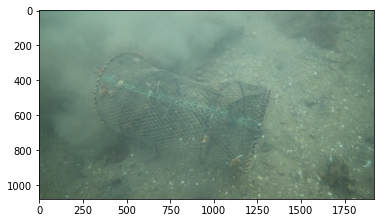

In [10]:

sampleImage = os.path.join(DATA_DIR, 'train', 'images', img[4])

def getImg(path):
    bgr_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    return rgb_image

sampleImage = getImg(sampleImage)
plt.imshow(sampleImage)

 * train.csv 확인

In [11]:
train_csv = pd.read_csv(os.path.join(DATA_DIR, 'train', 'train.csv'))
train_csv.sample(n=10)

,file_name,category
3337,vtxLmGV8dPf3KUb.jpg,spring fish trap
5144,v9SWyDCGOpW3lqf.jpg,tire
5062,gSBCKH1rVeUYn1I.jpg,tire
4417,SWXiPp4ukSMPEdM.jpg,tire
1615,gbhPLXw0w6ZUU6y.jpg,eel fish trap
5428,jAylYCIW9whyMTD.jpg,tire
6188,vXjxnx2J6ZMiLFA.jpg,wood
132,wQXxgICDBdSZSvK.jpg,bundle of ropes
308,XbXr5IrY7PPSiNY.jpg,bundle of ropes
5160,ecoX69b9WETIpPW.jpg,tire


 * 학습 데이터의 쓰레기 분류 분포

In [12]:
train_csv.groupby('category').count()

,file_name
category,
bundle of ropes,417
circular fish trap,807
eel fish trap,401
fish net,564
other objects,7
rectangular fish trap,180
rope,429
spring fish trap,925
tire,1836


 * 카테고리 딕셔너리 생성

In [13]:
category_list = train_csv['category'].unique()
category = {}
for i in range(len(category_list)):
    category[category_list[i]] = i

print(category)
print(category.keys())

{'bundle of ropes': 0, 'circular fish trap': 1, 'eel fish trap': 2, 'rope': 3, 'fish net': 4, 'other objects': 5, 'rectangular fish trap': 6, 'tire': 7, 'spring fish trap': 8, 'wood': 9}
dict_keys(['bundle of ropes', 'circular fish trap', 'eel fish trap', 'rope', 'fish net', 'other objects', 'rectangular fish trap', 'tire', 'spring fish trap', 'wood'])


### 데이터 전처리 방법
#### 해당 데이터에는 전처리가 적용된 이미지이지만 전처리 방법 소개
 * resize : 이미지 파일의 크기가 너무 커서 학습 시간이 오래 걸리거나, 각 이미지 파일의 크기가 다른 점을 보정하기 위해 지정된 규격으로 이미지 크기 통일
 * interpolation : 이미지의 비율을 변경할 때 존재하지 않는 영역에 새로운 픽셀 값을 매핑하거나, 존재하는 픽셀들을 압축하여 새로운 값을 할당. 새로운 픽셀 값은 interpolation(보간법)을 이용하여 구함.
 

## 3. 데이터 로드
### 사용할 파라미터
 * BATCH_SIZE : 모델에 입력할 데이터의 단위. 전체 데이터 셋을 여러개의 소그룹으로 나누어 학습하게 되는데, batch size는 하나의 소그룹에 속하는 데이터 수가 된다

In [14]:
# 데이터 로드 파라미터
BATCH_SIZE = 128
INPUT_SHAPE = (128, 128)

# train, validation 비율
VAL_RATIO = 0.2

In [18]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = os.path.join(data_dir, 'train')
        self.mode = mode
        self.input_shape = input_shape
        self.db = self.data_loader()
        self.transform = transforms.Compose([transforms.Resize(self.input_shape), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 
        self.class_num = len(self.db['label'].unique())

    def data_loader(self):
        print("Loading " + self.mode + " dataset...")

        img_dir = os.path.join(self.data_dir, 'images')
        label_dir = os.path.join(self.data_dir, 'train.csv')

        #이미지 폴더 존재 여부 체크
        if not os.path.isdir(img_dir):
            print(f'!!! Cannot find {img_dir} !!!')
            sys.exit()

        #라벨 파일 존재 여부 체크
        if not os.path.lexists(label_dir):
            print(f'!!! Cannot find {label_dir} !!!')
            sys.exit()

        category_ls = list(category.keys())

        # train.csv를 pandas로 불러오기
        df = train_csv

        # return할 train, val 데이터 초기화
        db_train = db_val = pd.DataFrame(columns=['img_path','label'])

        # 카테고리별로 train/val 비율 맞춰 나누기 위해 카테고리별로 루프 실행
        for cat in category_ls:
            img_path_list = []
            img_label_list = []

            # 특정 카테고리에 해당하는 이미지 리스트 뽑기
            img_list = df['file_name'].loc[df['category']==cat].values

            for filename in img_list:
                if os.path.lexists(os.path.join(img_dir, filename)):
                    img_path_list.append(os.path.join(img_dir, filename))
                    img_label_list.append(category[cat])
            
            db = pd.DataFrame({'img_path': img_path_list, 'label':img_label_list})

            # 학습, 검증 셋 나누기
            train, val = train_test_split(db, test_size=VAL_RATIO, random_state=42, shuffle=True)

            db_train = pd.concat([db_train, train])
            db_val = pd.concat([db_val, val])

        db_train = db_train.sample(frac=1).reset_index(drop=True)
        db_val = db_val.sample(frac=1).reset_index(drop=True)

        if self.mode == 'train':
            db = db_train
        elif self.mode == 'val':
            db = db_train
        else:
            print('check your mode : ')
        
        print(db.head())
        return db

    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        #1. load image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])
        
        #2. preprocessing imges
        trans_imge = self.transform(Imgae.fromarray(cvimg))
        return trans_image, data['label']



train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading train dataset...
                                img_path label
0  data/train/images/30NeZHMrB1TuXTK.jpg     1
1  data/train/images/UHFcebDE9H0LDpL.jpg     8
2  data/train/images/KmwfNBRy9b1LDMu.jpg     0
3  data/train/images/gSBCKH1rVeUYn1I.jpg     7
4  data/train/images/Egt2dL41HvB2tlY.jpg     7
Loading val dataset...
                                img_path label
0  data/train/images/TAPlGYffGUu6SDz.jpg     8
1  data/train/images/nKKsD9BHH2qpV44.jpg     8
2  data/train/images/5SjnoCgbxbvotGX.jpg     8
3  data/train/images/2rjHYWJs0JBCJHw.jpg     1
4  data/train/images/phCKGiezC9BeyjN.jpg     4


### 모델 설계 / pretrained model 불러오기
#### 사용할 파라미터
 * LEARNING_RATE : 
  * 경사하강법을 통해 loss function의 minimum 값을 찾아다닐 때, 그 탐색 과정에 있어서의 보폭
 * EPOCHS : 
  * 한번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass / backward pass 과정을 거친 것
  * epoch가 1만큼 지나면, 전체 데이터 셋에 대해 한번의 학습이 완료 된것
  * 모델을 만들 때 적절한 epoch 값을 설정 해야만 underfitting 과 overfitting을 방지
 * EARLY_STOPPING_PATIENCE : 
  * 너무 많은 epoch는 overfitting을 일으키고 너무 적은  epoch는 underfitting을 일으키므로 특정 시점에 학습을 멈추는 방법이 early stopping
  * 해당 변수는 validation score 가 개선되지 않아도 학습을 몇 에폭 더 진행할지 결정.
 * WEIGHT_DECAY : 
  * orverfitting을 억제하는 학습 기법의 하나로, 학습된 모델의 복잡도를 줄이기 위해서 학습 중  weight가 너무 큰 값을 가지지 않도록 Loss function에 Weight가 커질 경우에 대한 패널티 항목을 넣는다

In [30]:
# hyper-parameters
LEARNING_RATE = 0.0005
EPOCHS = 10

EARLY_STOPPING_PATIENCE = 10
WEIGHT_DECAY = 0.00001

OPTIMIZER = ''
SCHEDULER = ''
MOMENTUM = ''
LOSS_FN = ''
METRIC_FN = ''

In [24]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=9831d18965b79853ebda9d144ba8888cbe43e4faf875201231f5dae0948ff500
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [26]:
import torch
from torch import nn
from torch.nn import functional as F
from efficientnet_pytorch import EfficientNet

class TrashClassifier(nn.Module):
    def __init__(self, num_class):
        super(TrashClassifier, self).__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_class)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x

# 모델 생성
model = TrashClassifier(num_class=train_dataset.class_num).to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


### 학습에 필요한 함수 설정
 * optimizer : 
  * 손실함수 값이 최소가 되는 부분을 찾기 위해 학습율과 기울기를 다양하게 수정하여 가중치를 변경시키는 것을 최적화라 하고, 최적화의 다양한 방식들을 옵티마이저라 한다.
 * scheduler : 
  * Learning rate scheduler는 미리 학습 일정을 정해두고, 그 일정에 따라 학습률을 조정하게 한다. 다시말해 Learning rate가 어떻게 변화하게 할지 정한다
 * metric_fn : 
  * 학습에서 평가지표(metric)는 validation에서 훈련된 모델이 얼마나 잘 학습되고 있는지 확인하며, 훈련 과정을 모니터링 하는데 사용

In [31]:
import sklearn.metrics as metrics

def get_metric_fn(y_pred, y_answer, y_prod):
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    f1 = metrics.f1_score(y_answer, y_pred, average="macro")
    return f1, 1

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
criterion = nn.CrossEntropyLoss()
metric_fn = get_metric_fn

### Trainer 설정
 * epoch 별 학습/검증 절차를 정의

In [ ]:
import tqdm

class Trainer():
    def __init__(self, criterion, model, device, metric_fn, optimizer=None, scheduler=None, logger=None):
        self.criterion = criterion
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.logger = logger
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        #한 epoch에서 수행되는 학습 절차
        